# Classifiez automatiquement des biens de consommation
## Notebook 2 : Faisabilité de classification d'images via SIFT
OpenClassrooms - Parcours Data Scientist - Projet 06  

## Présentation du projet

**Contexte**  


* **Place de marché** souhaite lancer une marketplace e-commerce anglophone  
* Les vendeurs proposent des articles à des acheteurs en postant une photo et une description  
* Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, elle est peu fiable. Le volume des articles est très petit  
* Il devient nécessaire d'**automatiser la tâche d‘attribution de la catégorie**

**Missions**  
* **Étude de faisabilité** (ce Notebook)  
* Classification supervisée à partir des images (Notebook 2)

**Étude de faisabilité**  
* Analyser les descriptions textuelles et les images des produits pour démontrer la faisabilité de regrouper automatiquement des produits de même catégorie
* Étapes :  
   * **Prétraitement** des données texte et image   
   * **Extraction** de features\*
   * **Réduction** en 2 dimensions -> scatterplot avec colorisation de la catégorie réelle
   * **Analyse des graphiques**
   * Réalisation d'une **mesure de similarité** entre les catégories réelles et celle issues d'une segmentation en clusters
* \*Extraction des features **texte** :  
   * 2 approches de type bag-of-words, comptage simple de mots et Tf-idf  
   * 1 approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText)
   * 1 approche de type word/sentence embedding avec BERT
   * 1 approche de type word/sentence embedding avec USE (Universal Sentence Encoder)
* \*Extraction des features **image** :  
   * 1 algorithme de type SIFT / ORB / SURF
   * 1 algorithme de type CNN Transfer Learning 

## Sommaire  
**Préparation de l'environnement**  
* Environnement virtuel
* Import des modules
* Fonctions
* Chargement du dataset  

# 1 Préparation de l'environnement

## 1.1 Environnement virtuel

In [1]:
# Vérification environnement virtuel
envs = !conda env list
print(f"Environnement virtuel : {[e for e in envs if '*' in e][0].split('*')[1].strip()}")

Environnement virtuel : C:\Users\chrab\anaconda3\envs\opc6_1


## 1.2 Import des modules

* Installation conditionnelle des librairies

In [2]:
import sys
import subprocess
import pkg_resources

def install_package(package):
    """Installe une librairie en mode silencieux si elle n'est pas encore installée"""
    try:
        pkg_resources.get_distribution(package)
    except pkg_resources.DistributionNotFound:
        print(f"Installation {package}... ", end='')
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        print(f"Terminé.")
    else:
        print(f"{package} est déjà installé.")

In [3]:
# Installation des librairies
install_package('numpy')
install_package('pandas')
install_package('opencv-contrib-python')
install_package('matplotlib')
install_package('seaborn')
install_package('scikit-learn')

numpy est déjà installé.
pandas est déjà installé.
opencv-contrib-python est déjà installé.
matplotlib est déjà installé.
seaborn est déjà installé.
scikit-learn est déjà installé.


* Import des modules

In [4]:
# Import des modules
import os
import time

import pandas as pd
import numpy as np

import cv2

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# from sklearn.cluster import KMeans
# from sklearn.manifold import TSNE

# from utils import get_dataframe_infos, plot_distribution

* Paramétrages

In [5]:
# FAST_MODE = False # Force l'exécution du code concerné, et écrase les fichiers s'ils existent
FAST_MODE = True

In [6]:
# Nombre de coeurs disponibles
print(os.cpu_count())

16


In [7]:
# Nombre de coeurs à utiliser
NUM_CORES = 8

# 2 Préparation du dataset

## 2.1 Chargement

In [8]:
# Conversion du fichier csv en DataFrame
df_datas = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [9]:
# Affichage de quelques lignes avec les features clés
display(df_datas[['image', 'product_category_tree']].head(3))

,image,product_category_tree
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"[""Home Furnishing >> Curtains & Accessories >>..."
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."


## 2.2 Création des labels des images

* Création d'un DataFrame avec :
    * nom du fichier image (`image`)  
    * nom de la catégorie (`label_name`)  
    * numéro de la catégorie (`label`)

In [10]:
# Récupération des noms de catégories principales
df_datas['label_name'] = df_datas['product_category_tree'].apply(lambda x: x.split('["')[1].split(' >>')[0])

# Encodage des labels
category_label_encoder = LabelEncoder()
df_datas['label'] = category_label_encoder.fit_transform(df_datas['label_name'])

# Suppression des colonnes inutilisées
df_datas = df_datas[['image', 'label_name', 'label']]

In [11]:
display(df_datas)

,image,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4
...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,0


In [12]:
df_datas.groupby('label').count()

,image,label_name
label,,
0,150,150
1,150,150
2,150,150
3,150,150
4,150,150
5,150,150
6,150,150


In [13]:
# Liste des labels dans l'ordre de l'encodage
label_names = category_label_encoder.classes_
print(label_names)

['Baby Care' 'Beauty and Personal Care' 'Computers'
 'Home Decor & Festive Needs' 'Home Furnishing' 'Kitchen & Dining'
 'Watches']


## 2.3 Affichages d'exemples par catégories

In [14]:
# Répertoire où se trouvent les fichiers images
images_path = './images/'

Catégorie : Baby Care


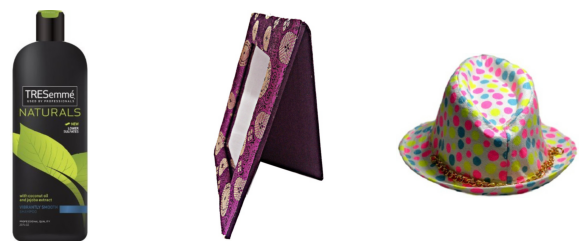


Catégorie : Beauty and Personal Care


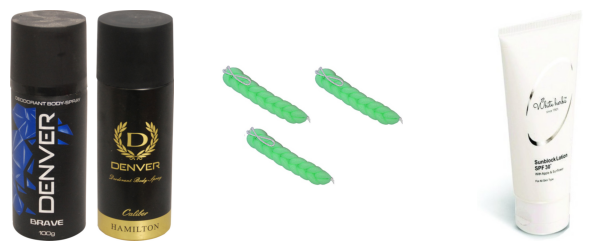


Catégorie : Computers


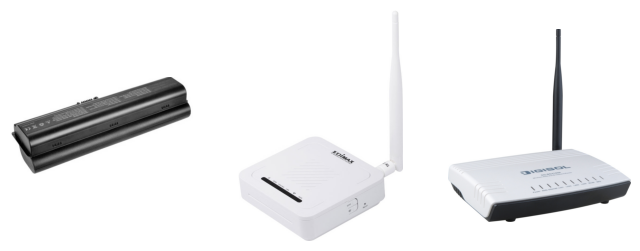


Catégorie : Home Decor & Festive Needs


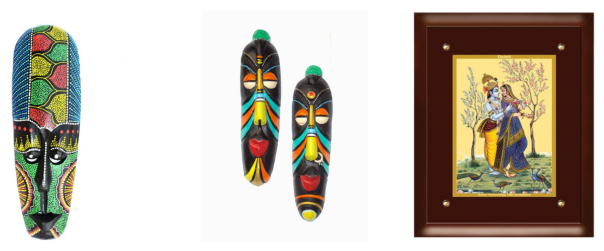


Catégorie : Home Furnishing


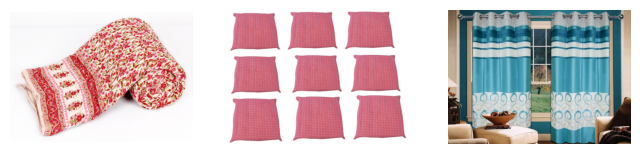


Catégorie : Kitchen & Dining


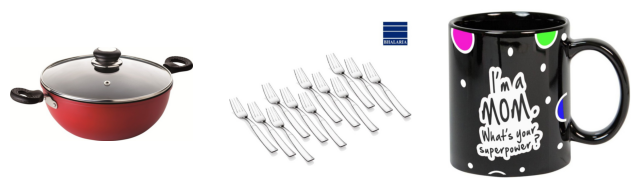


Catégorie : Watches


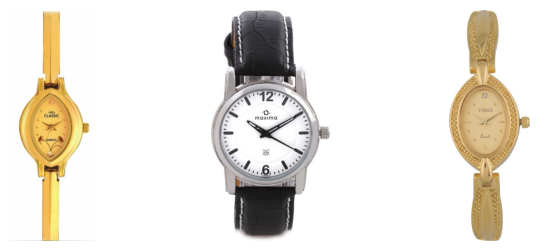

In [15]:
# Affichage de 3 images de chaque catégorie
for category in label_names:
    mask = df_datas['label_name'] == category
    images = df_datas.loc[mask, 'image'].sample(3).values
    print(f"Catégorie : {category}")
    plt.figure(figsize=(8, 3))
    for i in range(3):
        plt.subplot(131 + i)
        filename = images_path + images[i]
        image = imread(filename)
        plt.imshow(image)
        plt.axis('off')
    plt.show()
    print()

# 3 Pré-traitement des images

Avant de procéder à un pré-traitement global, chaque étape est détaillée pour une image

* Fonction d'affichage d'un histogramme

In [16]:
def plot_histogram(image):
    color = ('r', 'g', 'b')
    for i, col in enumerate(color):
        histogram = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(histogram, color = col)
    plt.title('Histogramme')
    plt.xlim([0, 256])
    plt.show()

## 3.1 Pré-traitement d'une image

### 3.1.1 Chargement et affichage d'une image originale

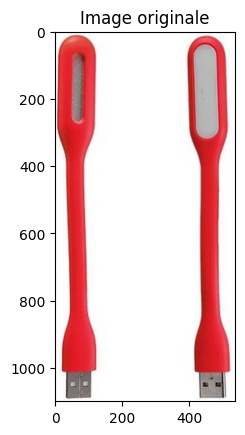

In [17]:
# Récupération du nom de fichier d'une image
image_file = df_datas['image'].sample(1).values[0]
# image_file = df_datas.iloc[859]['image']

# Affichage
image = cv2.imread(images_path + image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title('Image originale')
plt.show()

### 3.1.2 Redimensionnement 256 x 256

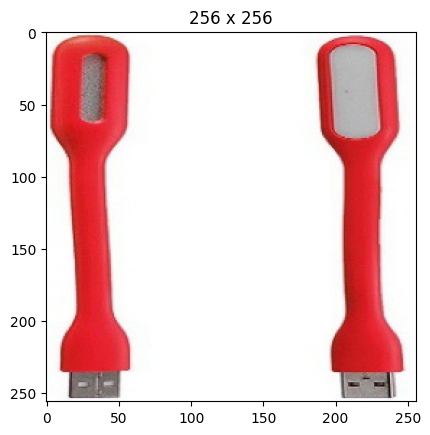

In [18]:
# Redimensionnement
image_resized = cv2.resize(image, (256, 256))
plt.imshow(image_resized)
plt.title('256 x 256')
plt.show()

### 3.1.3 Filtrage de bruit

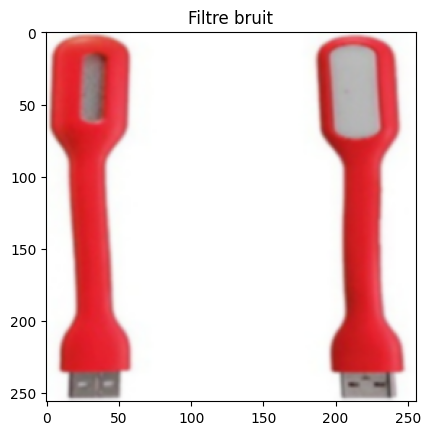

In [19]:
# Filtrage de bruit
image_filtered = cv2.GaussianBlur(image_resized, (5, 5), 0)
plt.imshow(image_filtered)
plt.title('Filtre bruit')
plt.show()

### 3.1.4 Conversion en niveau de gris

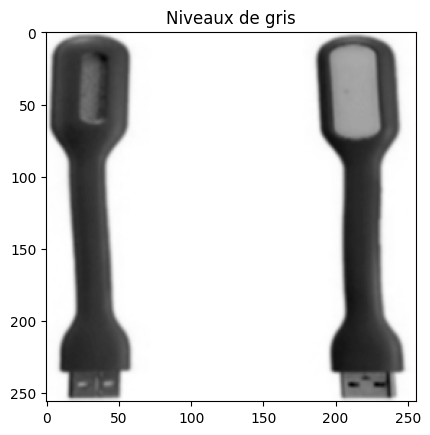

In [20]:
# Conversion en niveaux de gris
image_gray = cv2.cvtColor(image_filtered, cv2.COLOR_RGB2GRAY)
plt.imshow(image_gray, cmap='gray')
plt.title('Niveaux de gris')
plt.show()

### 3.1.5 Equalisation

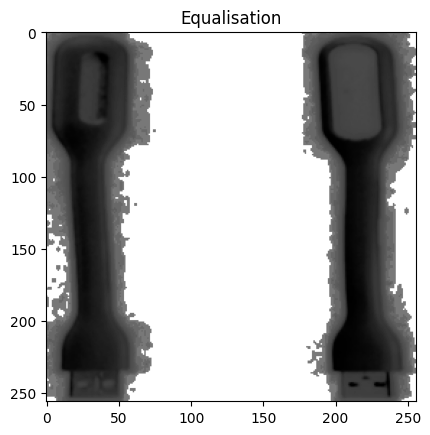

In [21]:
sift = cv2.xfeatures2d.SIFT_create()
image_equalized = cv2.equalizeHist(image_gray)
plt.imshow(image_equalized, cmap='gray')
plt.title('Equalisation')
plt.show()

### 3.1.6 Récupération et affichage des descripteurs SIFT

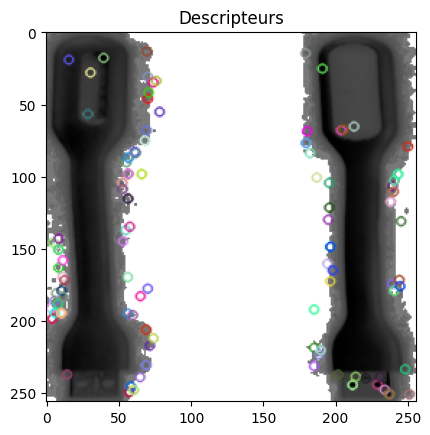

Descripteurs :  (128, 128)

[[ 17.  14.   6. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [ 19.  19.   0. ...   8.   4.   9.]
 ...
 [ 94.  20.   0. ...   0.   0.   6.]
 [ 27. 153.  41. ...   0.   0.   0.]
 [ 69.   0.   0. ...   0.   0.   1.]]


In [22]:
keypoints, descriptors = sift.detectAndCompute(image_equalized, None)
img = cv2.drawKeypoints(image_equalized, keypoints, image_equalized)
plt.imshow(img)
plt.title('Descripteurs')
plt.show()

print("Descripteurs : ", descriptors.shape)
print()
print(descriptors)

## 3.2 Pré-traitement de toutes les images

### 3.2.1 Récupération des descripteurs

In [23]:
num_images = df_datas.shape[0]

sift_keypoints = []
sift_descriptors = []

start_sift = time.perf_counter()
sift = cv2.xfeatures2d.SIFT_create()

print('Pré-traitement des images', end='')
for image_number, image_filename in enumerate(df_datas['image'].values):
    if image_number % 25 == 0: print('.', end='')

    # Chargement image
    image = cv2.imread(images_path + image_filename)

    # Pré-traitement
    image = cv2.resize(image, (256, 256)) # Redimensionnement
    image = cv2.GaussianBlur(image, (5, 5), 0) # Filtre bruit
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Nuances de gris
    image = cv2.equalizeHist(image) # Equalisation (contraste)

    # Récupération des descripteurs
    keypoints, descriptors = sift.detectAndCompute(image, None)

    if descriptors is None:
        print(f"L'image {i} ({filename}) n'a pas de descripteurs !")
        
    # Nombre de descripteurs pour chaque image
    sift_keypoints.append(len(keypoints))

    # Sauvegarde des descripteurs
    # sift_descriptors.append(descriptors)
    if image_number == 0:
        descriptors_array = np.asarray(descriptors)
    else:
        descriptors_array = np.concatenate([descriptors_array, np.asarray(descriptors)], axis=0)
    
end_sift = time.perf_counter()
sift_duration = end_sift - start_sift

# print(f'\nNombre de descripteurs : {sift_keypoints_all.shape}')
print(f'\nDurée de traitement : {sift_duration:.2f} secondes')

Pré-traitement des images..........................................
Durée de traitement : 61.37 secondes


### 3.2.2 Création des clusters de descripteurs

* Création des cluster par segmentation de tous les descripteurs, quelle que soit l'image à laquelle ils appartiennent  
* Utilisation de MiniBatchKMeans pour optimiser les temps de traitement  
* Nombre de clusters fixé à la racine carrée du nombre de descripteurs  

In [24]:
start_kmeans = time.perf_counter()

# Nombre de clusters
# n_clusters = int(round(np.sqrt(len(descriptors_array)), 0))
n_clusters = 100

# Création des clusters
kmeans = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++', random_state=0)
kmeans.fit(descriptors_array)

end_kmeans = time.perf_counter()
kmeans_duration = end_kmeans - start_kmeans

print(f'\nNombre de clusters de descripteurs : {n_clusters}')
print(f'Durée de traitement : {kmeans_duration:.2f} secondes')


Nombre de clusters de descripteurs : 100
Durée de traitement : 2.52 secondes


### 2.3.3 Création des features

* Features d'une image = fréquences des descripteurs de l'image dans chaque cluster, pondérées par le nombre de descripteurs de l'image (histogramme)

In [25]:
# Fonction de création d'un histogramme
def build_histogram(kmeans_model, descriptors, image_id):
    number_of_descriptors = len(descriptors)
    if number_of_descriptors == 0: print(f"\nAucun descripteur pour l'image {image_id}")
    labels = kmeans_model.predict(descriptors)
    histogram = np.zeros(len(kmeans_model.cluster_centers_))
    for label in labels:
        histogram[label] += 1.0 / number_of_descriptors
    return histogram

In [26]:
start_fc = time.perf_counter()

# Création d'une matrice d'histogrammes
histograms = []

last_index = 0
print("Création des histogrammes", end='')
for image_number in range(len(sift_keypoints)):
    if image_number % 25 == 0: print('.', end='')
    number_of_keypoints = sift_keypoints[image_number]
    start_index, last_index = last_index, last_index + number_of_keypoints
    descriptors = descriptors_array[start_index:last_index]
    histogram = build_histogram(kmeans, descriptors, image_number)
    histograms.append(histogram)
print()

end_fc = time.perf_counter()
fc_duration = end_fc - start_fc
print(f'Durée de traitement : {fc_duration:.2f} secondes')

Création des histogrammes..........................................
Durée de traitement : 3.24 secondes


# 4 Analyse visuelle

## 4.1 Réductions de dimension

### 4.1.1 Réduction de dimension via PCA

* L'ACP permet de créer des features décorrélées entre elles et de diminuer leur dimension, tout en gardant un pourcentage d'explication de la variance élevée (avec `n_components=0.99`)
* Elle permet une meilleure séparation des données pour la réduction de dimension via t-SNE à suivre

In [27]:
# Conversion des features sous forme d'un arrat numpy
histograms_array = np.asarray(histograms)

print(f"Dimension du dataset avant PCA : {histograms_array.shape}")
pca = PCA(n_components=0.99)
pca_features = pca.fit_transform(histograms_array)
print(f"Dimension du dataset après réduction PCA : {pca_features.shape}")

Dimension du dataset avant PCA : (1050, 100)
Dimension du dataset après réduction PCA : (1050, 90)


### 4.1.2 Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes t-SNE pour affichage en 2D de la représentation des images

In [28]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    n_iter=2000,
    init='random',
    random_state=0
)

X_tsne = tsne.fit_transform(pca_features)
# X_tsne = tsne.fit_transform(histograms_array)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne 1', 'tsne 2'])
df_tsne["Catégorie"] = df_datas["label_name"]

* Création de clusters KMeans

In [29]:
kmeans = KMeans(n_clusters=7, init='k-means++', random_state=0)
kmeans.fit(X_tsne)

df_tsne['Cluster'] = kmeans.labels_

## 4.2 Visualisations

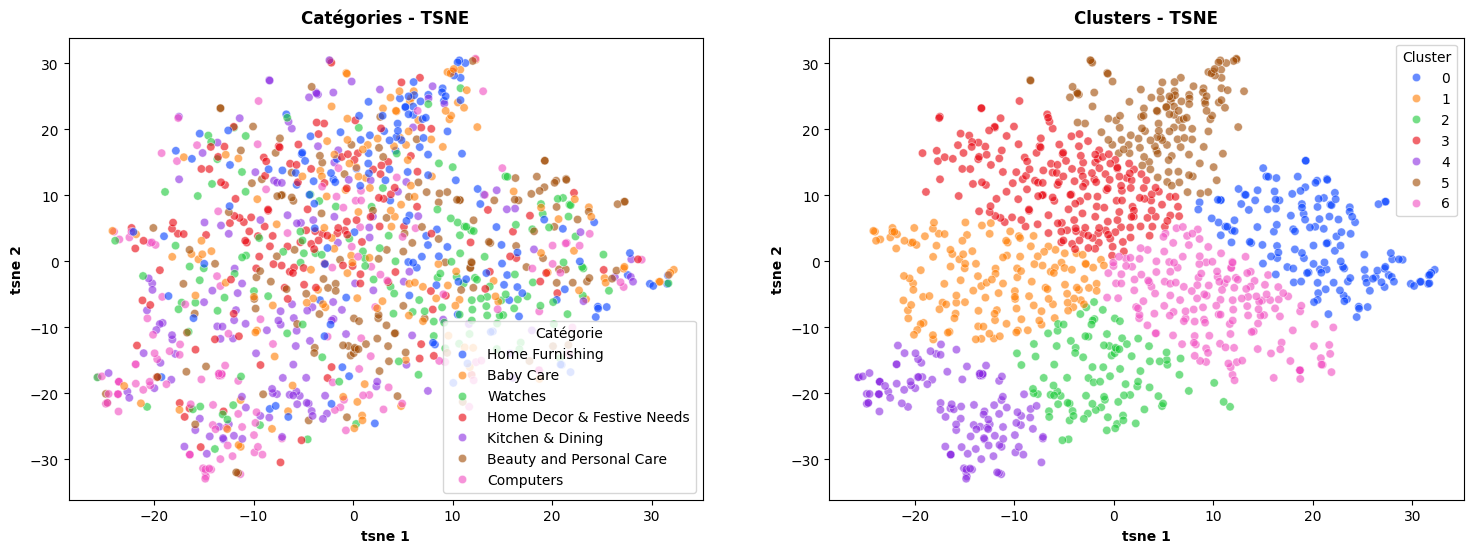

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

for i, criteria in enumerate(('Catégorie', 'Cluster')):
    sns.scatterplot(data=df_tsne, x='tsne 1', y='tsne 2', hue=criteria, palette='bright', alpha=0.6, ax=ax[i])
    ax[i].set_title(f"{criteria}s - TSNE", fontweight='bold', pad=10)
    ax[i].set_xlabel('tsne 1', fontweight = 'bold')
    ax[i].set_ylabel('tsne 2', fontweight = 'bold')

plt.show()

* Les catégories ne sont pas séparées  
* Les produits ne se regroupent pas, seuls les produits de la catégorie 'Watches' semblent légèrement plus nombreux dans le cluster 6...
* L'analyse visuelle ne confirme pas une faisabilité de classification via SIFT

# 5 Analyse métriques

* Le très faible score ARI de 0.05 confirme l'analyse visuelle

In [34]:
ari_score = adjusted_rand_score(df_datas['label'], kmeans.labels_)
print(f"Adjusted Rand Index  : {round(ari_score, 3)}")

Score ARI : 0.054


* Une matrice de confusion n'aurait pas de sens puisqu'il est impossible de rattacher les catégories aux clusters de manière relativement fiable